In [31]:
# 1 - Importações das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [32]:
# 2 - Definição das colunas, carregamento do dataset e salvamento em CSV
columns = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM",
    "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B",
    "LSTAT", "MEDV"
]

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
df = pd.read_csv(url, header=None, delim_whitespace=True, names=columns)

df.to_csv("boston.csv", index=False)


/tmp/ipython-input-997078125.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, header=None, delim_whitespace=True, names=columns)


In [33]:
# 3 - Verificação do formato (linhas x colunas) do DataFrame
df.shape


(506, 14)

In [34]:
# 4 - Verificação das linhas
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [35]:
# 5 - Significado das colunas do Boston Housing Dataset

# CRIM     → Taxa de criminalidade per capita por cidade
# ZN       → Proporção de terrenos residenciais para lotes > 25.000 pés²
# INDUS    → Proporção de acres de negócios não comerciais (áreas industriais)
# CHAS     → Dummy (0 ou 1): 1 se limita com o rio Charles, 0 caso contrário
# NOX      → Concentração de óxidos de nitrogênio (poluição do ar, partes por 10 milhões)
# RM       → Número médio de cômodos por residência
# AGE      → Proporção de unidades ocupadas construídas antes de 1940 (antiguidade das casas)
# DIS      → Distância ponderada até 5 centros de emprego de Boston
# RAD      → Índice de acessibilidade às rodovias radiais
# TAX      → Taxa de imposto sobre propriedade por $10.000
# PTRATIO  → Razão aluno/professor nas escolas da cidade
# B        → 1000(Bk - 0.63)², onde Bk é a proporção de pessoas negras na cidade
# LSTAT    → % da população em status socioeconômico mais baixo
# MEDV     → Valor mediano das casas ocupadas por proprietários (em milhares de dólares)

In [36]:
# 6 - Verificação de valores nulos em cada coluna do dataset
df.isnull().sum()


,0
CRIM,0
ZN,0
INDUS,0
CHAS,0
NOX,0
RM,0
AGE,0
DIS,0
RAD,0
TAX,0


In [37]:
# 7 - PRÉ-PROCESSAMENTO: Tratamento de valores ausentes
# Substitui valores ausentes: numéricos pela média e categóricos pela moda

def trata_faltantes(df):
    df = df.copy()

    # Identifica colunas numéricas e categóricas
    colunas_numericas = df.select_dtypes(include=['number']).columns
    colunas_categoricas = df.select_dtypes(include=['object', 'category']).columns

    # Preenche colunas numéricas com a média
    for col in colunas_numericas:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].mean())

    # Preenche colunas categóricas com a moda
    for col in colunas_categoricas:
        if df[col].isnull().sum() > 0:
            moda_serie = df[col].mode()
            if not moda_serie.empty:
                df[col] = df[col].fillna(moda_serie.iloc[0])

    return df

# Aplica a função ao dataset
df = trata_faltantes(df)

print("✅ Valores ausentes tratados.")
print(df.info())
print(df.head())


✅ Valores ausentes tratados.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB
None
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.96

In [38]:
# 8 - PRÉ-PROCESSAMENTO: Limpeza de valores inválidos
# Remove ou filtra registros com valores fora dos limites esperados

def limpar_valores_invalidos_boston(df):
    df_original = df.copy()
    total_inicial = len(df)

    def filtrar(df, condicao, nome):
        antes = len(df)
        df_filtrado = df[condicao]
        print(f"{nome}: {antes - len(df_filtrado)} registros removidos")
        return df_filtrado

    df = filtrar(df, df['CRIM'] >= 0, "CRIM inválido")
    df = filtrar(df, df['ZN'] >= 0, "ZN inválido")
    df = filtrar(df, df['INDUS'] >= 0, "INDUS inválido")
    df = filtrar(df, df['CHAS'].isin([0,1]), "CHAS inválido")
    df = filtrar(df, df['NOX'] >= 0, "NOX inválido")
    df = filtrar(df, df['RM'] > 0, "RM inválido")
    df = filtrar(df, (df['AGE'] >= 0) & (df['AGE'] <= 100), "AGE inválido")
    df = filtrar(df, df['DIS'] >= 0, "DIS inválido")
    df = filtrar(df, df['RAD'] >= 1, "RAD inválido")
    df = filtrar(df, df['TAX'] > 0, "TAX inválido")
    df = filtrar(df, df['PTRATIO'] > 0, "PTRATIO inválido")
    df = filtrar(df, df['B'] >= 0, "B inválido")
    df = filtrar(df, df['LSTAT'] >= 0, "LSTAT inválido")
    df = filtrar(df, df['MEDV'] > 0, "MEDV inválido")

    print(f"\nTotal registros removidos: {total_inicial - len(df)}. Total final: {len(df)}")
    return df

# Aplica a função ao dataset
df = limpar_valores_invalidos_boston(df)


CRIM inválido: 0 registros removidos
ZN inválido: 0 registros removidos
INDUS inválido: 0 registros removidos
CHAS inválido: 0 registros removidos
NOX inválido: 0 registros removidos
RM inválido: 0 registros removidos
AGE inválido: 0 registros removidos
DIS inválido: 0 registros removidos
RAD inválido: 0 registros removidos
TAX inválido: 0 registros removidos
PTRATIO inválido: 0 registros removidos
B inválido: 0 registros removidos
LSTAT inválido: 0 registros removidos
MEDV inválido: 0 registros removidos

Total registros removidos: 0. Total final: 506


In [39]:
# 9 - PRÉ-PROCESSAMENTO: Remoção de duplicados
# Remove linhas exatamente iguais no dataset, mantendo apenas a primeira ocorrência

def remove_duplicados_exatos(df):
    antes = len(df)
    df = df.drop_duplicates(keep='first')  # mantém a primeira ocorrência e remove as demais
    removidos = antes - len(df)
    print(f"✅ Duplicados removidos: {removidos}. Total final: {len(df)}")
    return df

# Aplica a função ao dataset
df = remove_duplicados_exatos(df)


✅ Duplicados removidos: 0. Total final: 506


In [40]:
# 10 - PRÉ-PROCESSAMENTO: Normalização das colunas numéricas
# Normaliza todas as colunas numéricas, exceto a coluna alvo 'MEDV'

def normalizar_boston(df, colunas_numericas=None, excluir_label=True):
    df = df.copy()

    if colunas_numericas is None:
        colunas_numericas = df.select_dtypes(include='number').columns.tolist()

    # Exclui a coluna alvo 'MEDV' da normalização
    if excluir_label and 'MEDV' in colunas_numericas:
        colunas_numericas = [c for c in colunas_numericas if c != 'MEDV']

    X = df[colunas_numericas].values.astype(float)

    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    sigma[sigma == 0] = 1  # evita divisão por zero

    X_norm = (X - mu) / sigma
    df[colunas_numericas] = X_norm

    return df, mu, sigma, colunas_numericas

# Aplica a normalização ao dataset
df, mu, sigma, colunas_numericas = normalizar_boston(df)

print("✅ Normalização concluída.")
print(df.head())


✅ Normalização concluída.
       CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
0 -0.419367  0.284548 -1.286636 -0.272329 -0.144075  0.413263 -0.119895   
1 -0.416927 -0.487240 -0.592794 -0.272329 -0.739530  0.194082  0.366803   
2 -0.416929 -0.487240 -0.592794 -0.272329 -0.739530  1.281446 -0.265549   
3 -0.416338 -0.487240 -1.305586 -0.272329 -0.834458  1.015298 -0.809088   
4 -0.412074 -0.487240 -1.305586 -0.272329 -0.834458  1.227362 -0.510674   

        DIS       RAD       TAX   PTRATIO         B     LSTAT  MEDV  
0  0.140075 -0.981871 -0.665949 -1.457558  0.440616 -1.074499  24.0  
1  0.556609 -0.867024 -0.986353 -0.302794  0.440616 -0.491953  21.6  
2  0.556609 -0.867024 -0.986353 -0.302794  0.396035 -1.207532  34.7  
3  1.076671 -0.752178 -1.105022  0.112920  0.415751 -1.360171  33.4  
4  1.076671 -0.752178 -1.105022  0.112920  0.440616 -1.025487  36.2  


In [41]:
# 11 - Separação em features (X) e target (y) e divisão em treino/teste
# Separa colunas em X (todas exceto 'MEDV') e y (coluna alvo 'MEDV')
X = df.drop(columns=['MEDV'])
y = df['MEDV']

print(f"Shape X: {X.shape}, Shape y: {y.shape}")

# Divisão treino/teste: 80% treino, 20% teste, aleatoriedade controlada
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


Shape X: (506, 13), Shape y: (506,)
X_train: (404, 13), X_test: (102, 13)
y_train: (404,), y_test: (102,)


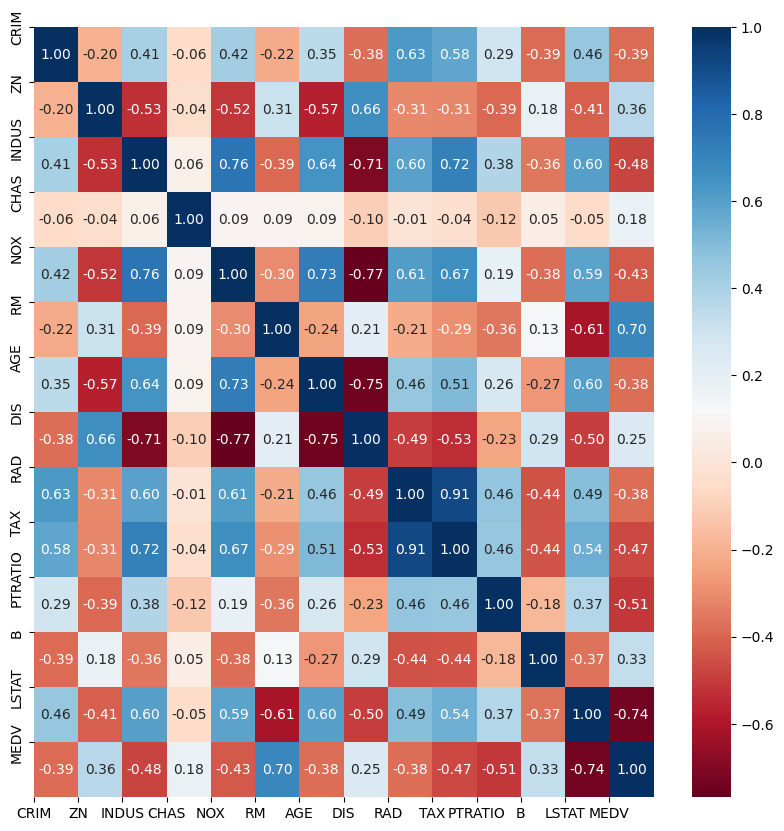

In [42]:
# 12 - Visualização: Mapa de calor das correlações entre variáveis
corr = df.corr()

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()



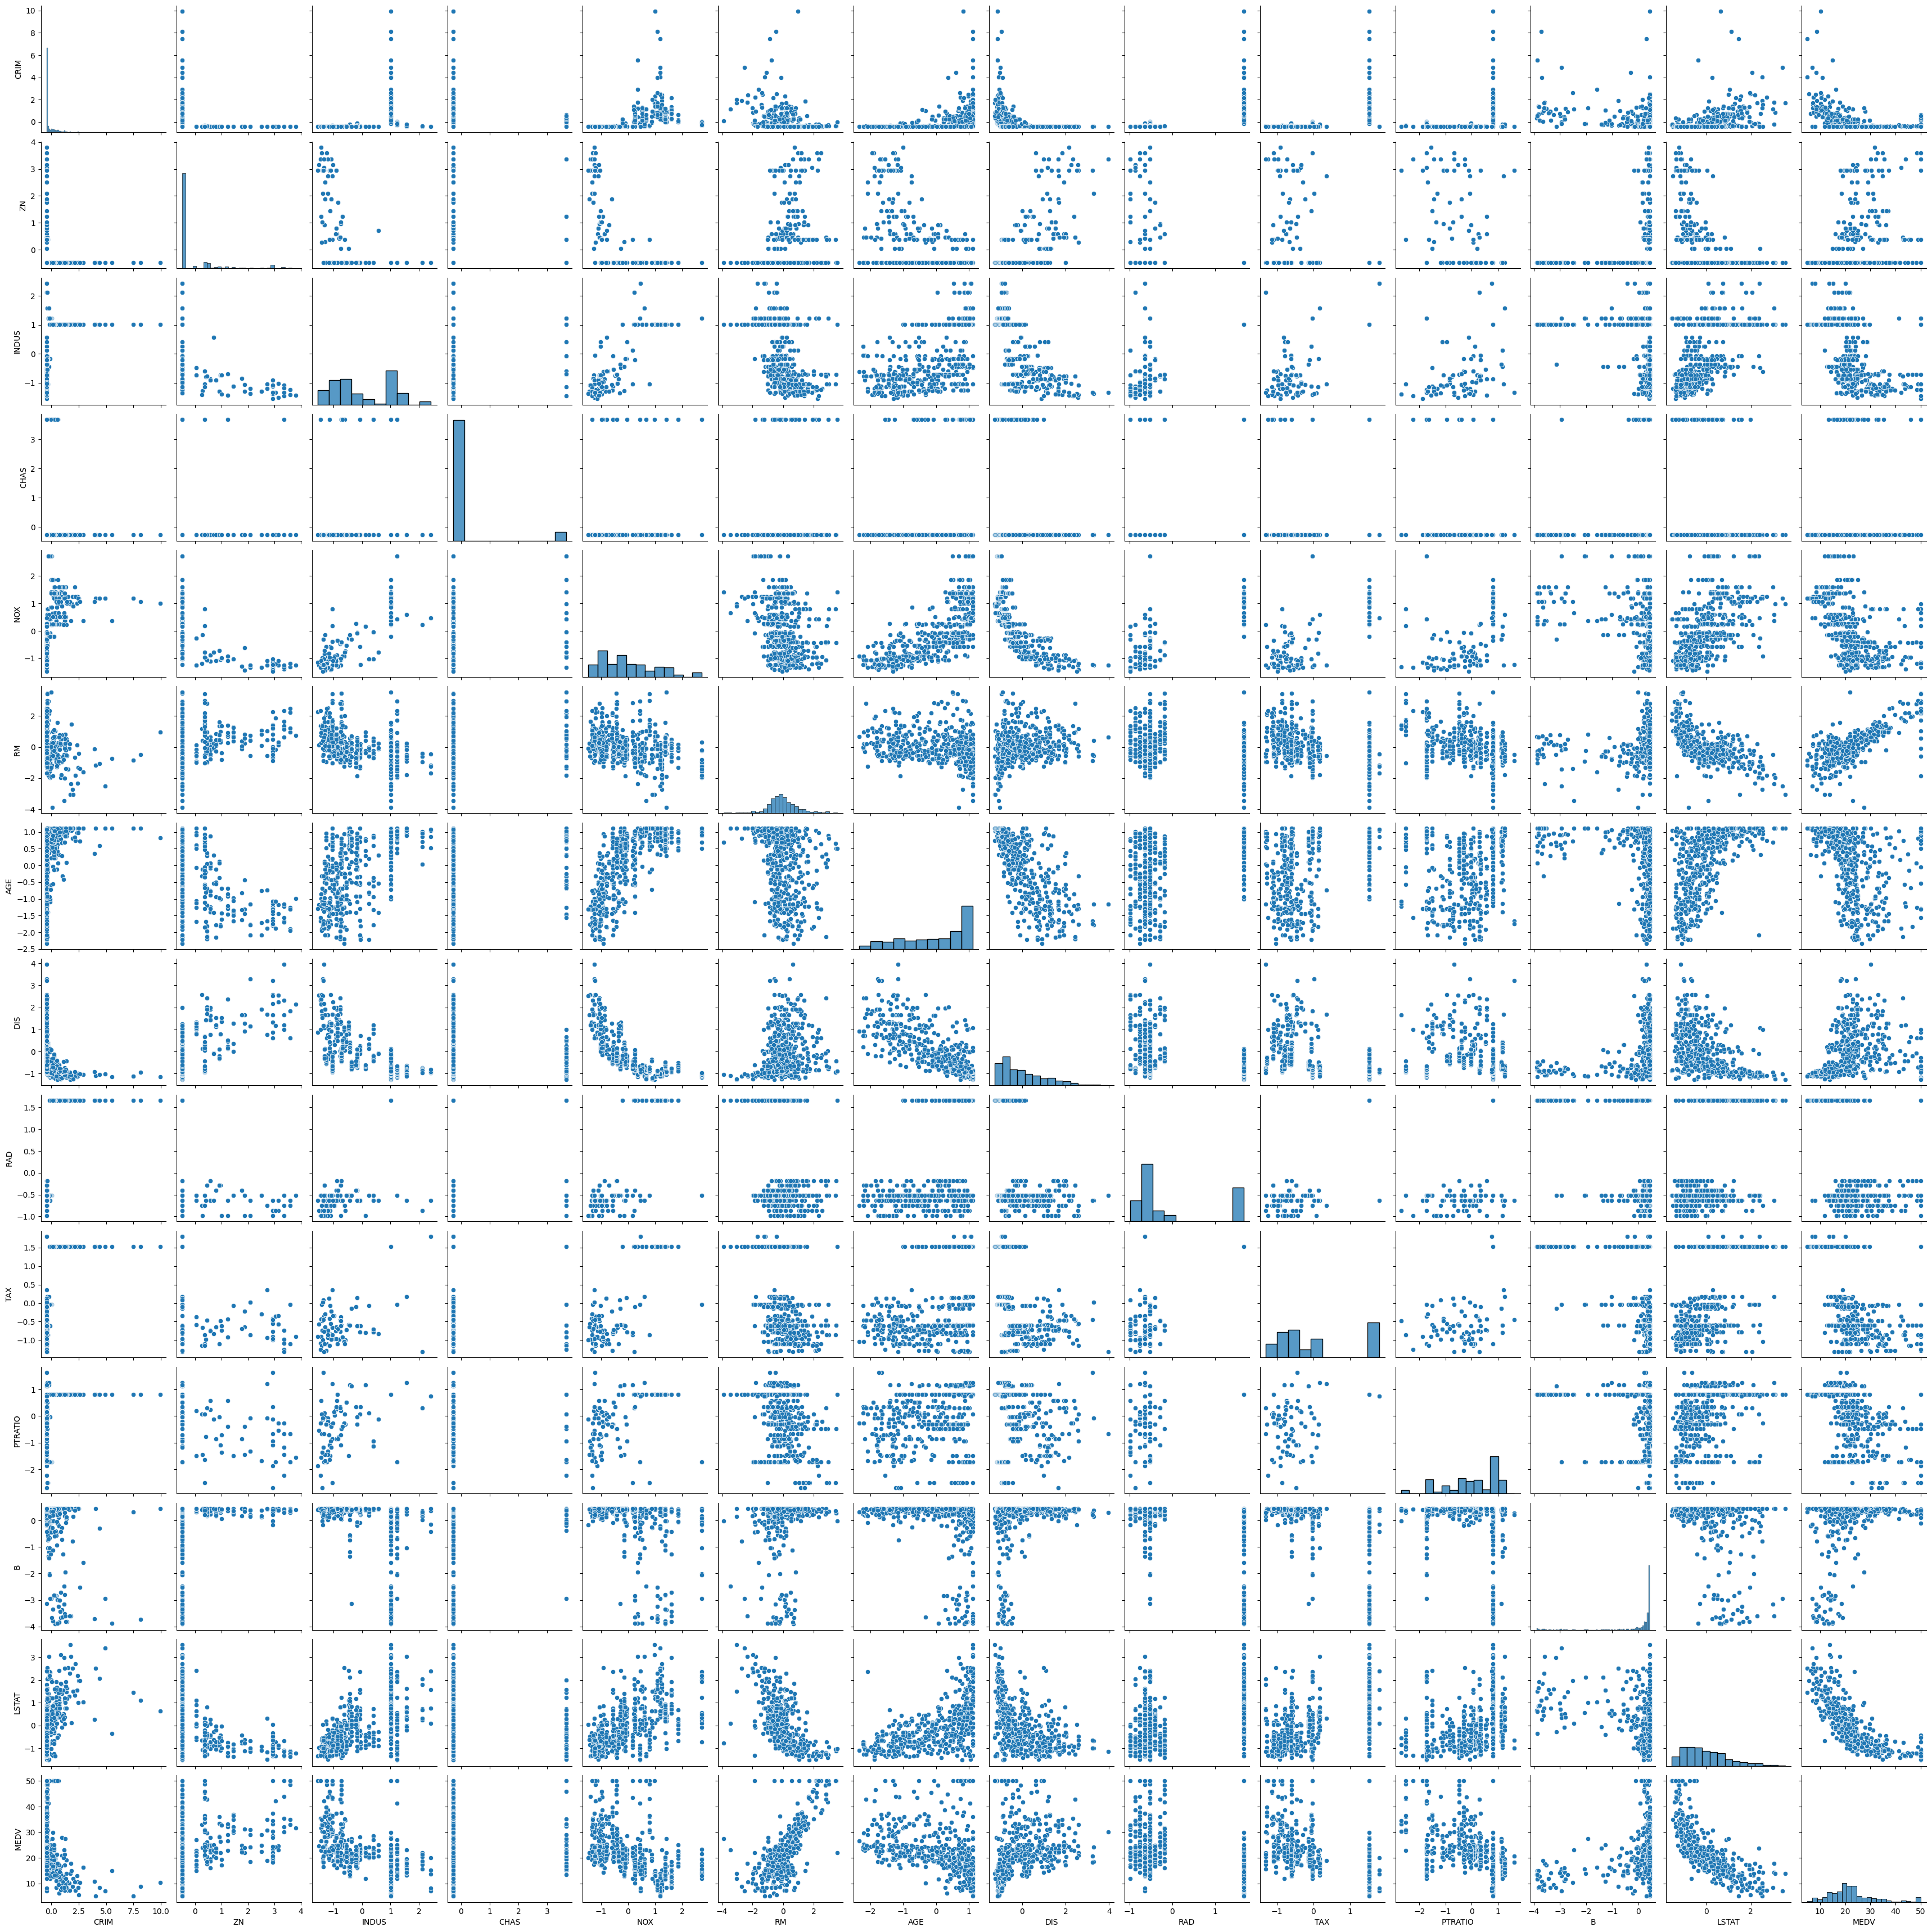

In [43]:
# 13 - Visualização: Pairplot das variáveis do dataset
sns.pairplot(df)
plt.show()


In [44]:
# 14 - Comparativo de modelos de regressão no Boston Housing Dataset

# Separação em features e target
X = df.drop("MEDV", axis=1)
y = df["MEDV"]

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Modelos de regressão
regressors = {
    "Regressão Linear": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5)
}

results = {}
for name, model in regressors.items():
    print(f"\n================ {name} ================")

    # Pipeline: normalização + modelo
    pipeline = Pipeline([("scaler", StandardScaler()), ("reg", model)])
    pipeline.fit(X_train, y_train)

    # Predição
    y_pred = pipeline.predict(X_test)

    # Métricas
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    results[name] = {"R²": r2, "RMSE": rmse, "MAE": mae}

# Comparativo final em tabela
results_df = pd.DataFrame(results).T.sort_values(by="R²", ascending=False)
print("\n Comparativo de Regressão:")
display(results_df)



================ Regressão Linear ================
R²: 0.6688
RMSE: 4.9286
MAE: 3.1891

================ Random Forest ================
R²: 0.8839
RMSE: 2.9180
MAE: 2.0422

================ KNN ================
R²: 0.7190
RMSE: 4.5393
MAE: 2.5922

🏆 Comparativo de Regressão:


,R²,RMSE,MAE
Random Forest,0.883889,2.918019,2.042167
KNN,0.719017,4.539331,2.592157
Regressão Linear,0.668759,4.928602,3.189092


In [46]:
# 15 - Comparativo de Regressão - Boston Housing Dataset
# -------------------------------------------------
# Métricas usadas:
# R²    → Quanto da variação do preço das casas o modelo consegue explicar (quanto maior, melhor)
# RMSE  → Erro médio quadrático das previsões em milhares de dólares (quanto menor, melhor)
# MAE   → Erro absoluto médio das previsões em milhares de dólares (quanto menor, melhor)
#
# Resultados:
# Random Forest:
#   R² = 0.88 → Explica 88% da variação dos preços
#   RMSE = 2.92 → Em média erra ~2.9 mil dólares
#   MAE = 2.04 → Em média erra ~2 mil dólares
#   Conclusão: Melhor modelo, alta precisão e boa capacidade de explicar variação
#
# KNN:
#   R² = 0.72 → Explica 72% da variação
#   RMSE = 4.54 → Em média erra ~4.5 mil dólares
#   MAE = 2.59 → Em média erra ~2.6 mil dólares
#   Conclusão: Médio, mais impreciso que Random Forest, mas melhor que Regressão Linear
#
# Regressão Linear:
#   R² = 0.67 → Explica 67% da variação
#   RMSE = 4.93 → Em média erra ~4.9 mil dólares
#   MAE = 3.19 → Em média erra ~3.2 mil dólares
#   Conclusão: Modelo simples, menos preciso, não captura bem relações não lineares
#
# Conclusão geral:
# O Random Forest é o modelo mais indicado para este dataset, pois combina alta explicação da variação (R²)
# com erros médios menores (RMSE e MAE). KNN e Regressão Linear são alternativas, mas menos precisas.


In [45]:
# 16 - Treinamento e avaliação do Random Forest Regressor no Boston Housing Dataset

# Separação em features e target
X = df.drop("MEDV", axis=1)
y = df["MEDV"]

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Pipeline: Normalização + Random Forest
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(n_estimators=200, random_state=42))
])

# Treinamento
rf_pipeline.fit(X_train, y_train)

# Predição
y_pred = rf_pipeline.predict(X_test)

# Métricas de avaliação
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Random Forest Regressor - Resultados:")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


Random Forest Regressor - Resultados:
R²: 0.8839
RMSE: 2.9180
MAE: 2.0422


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores parâmetros encontrados: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}


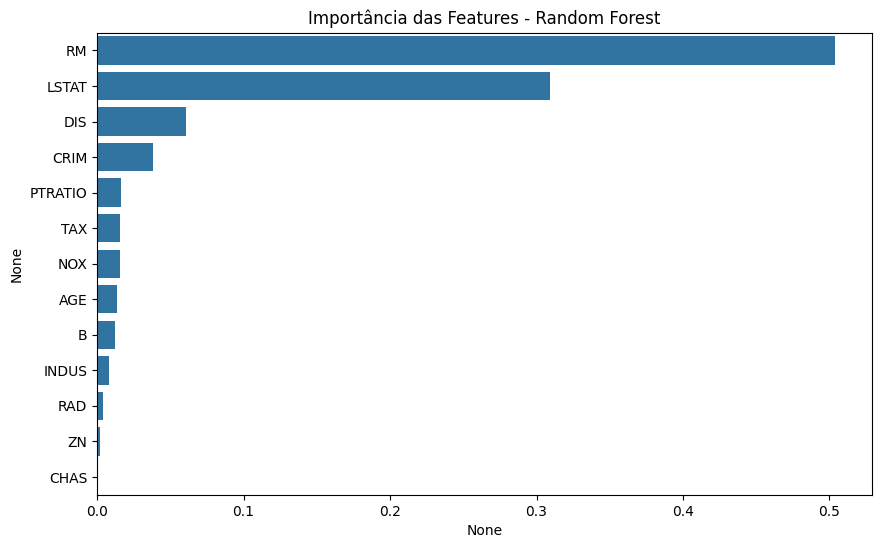

Features selecionadas: ['RM', 'LSTAT', 'DIS', 'CRIM', 'PTRATIO', 'TAX', 'NOX', 'AGE', 'B']


In [47]:
# 17 - Pipeline e GridSearch para Random Forest Regressor + Importância de Features
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(random_state=42))
])

# Definição dos hiperparâmetros para busca
param_grid = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_split": [2, 5]
}

# GridSearch com 5-fold cross-validation
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Melhores parâmetros encontrados:", grid.best_params_)

# Importância das features
best_model = grid.best_estimator_.named_steps['rf']
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title("Importância das Features - Random Forest")
plt.show()

# Seleção de features acima de um limiar
threshold = 0.01
selected_features = feature_importances[feature_importances > threshold].index.tolist()
print("Features selecionadas:", selected_features)



Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores parâmetros (features selecionadas): {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
R²: 0.8873, RMSE: 2.8744, MAE: 2.0129


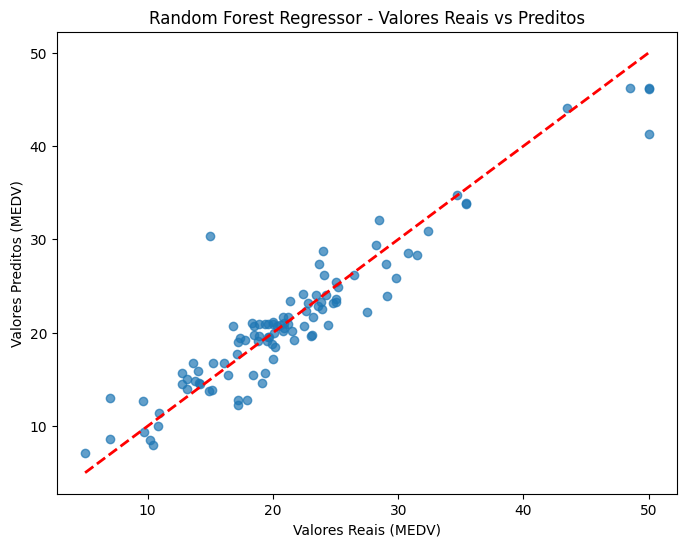

In [48]:
# 18 - Treinamento Random Forest usando apenas features selecionadas + Avaliação
# Preparar dados apenas com features selecionadas
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

# Pipeline e GridSearch
pipeline_sel = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(random_state=42))
])

grid_sel = GridSearchCV(
    pipeline_sel,
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)
grid_sel.fit(X_train_sel, y_train)

print("Melhores parâmetros (features selecionadas):", grid_sel.best_params_)

# Predição e métricas
y_pred_sel = grid_sel.predict(X_test_sel)
r2_sel = r2_score(y_test, y_pred_sel)
rmse_sel = np.sqrt(mean_squared_error(y_test, y_pred_sel))
mae_sel = mean_absolute_error(y_test, y_pred_sel)

print(f"R²: {r2_sel:.4f}, RMSE: {rmse_sel:.4f}, MAE: {mae_sel:.4f}")

# Visualização: Valores reais vs preditos
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_sel, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores Reais (MEDV)")
plt.ylabel("Valores Preditos (MEDV)")
plt.title("Random Forest Regressor - Valores Reais vs Preditos")
plt.show()


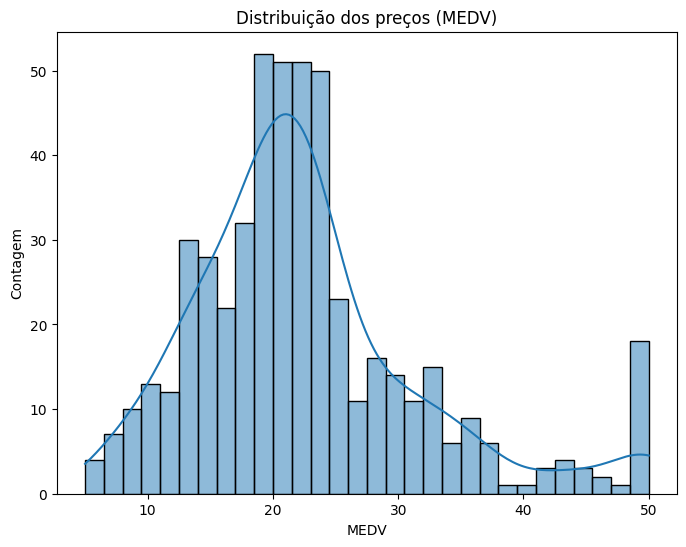

In [50]:
# 19 - Visualização: Distribuição do target (MEDV)
plt.figure(figsize=(8,6))
sns.histplot(df['MEDV'], bins=30, kde=True)
plt.title("Distribuição dos preços (MEDV)")
plt.xlabel("MEDV")
plt.ylabel("Contagem")
plt.show()


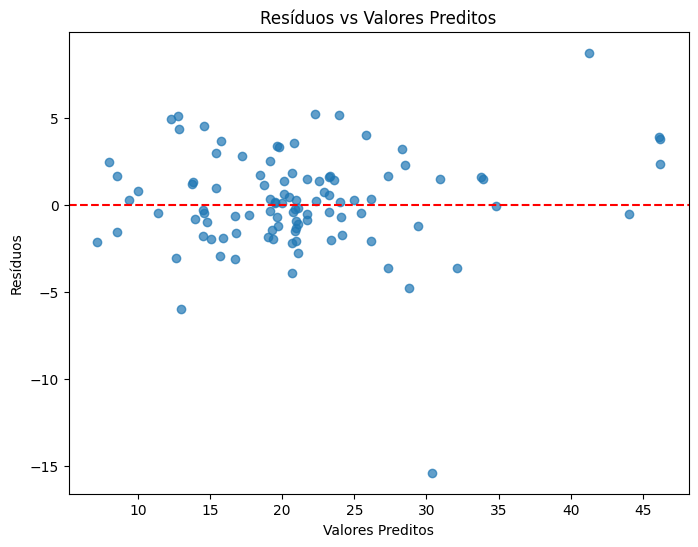

In [55]:
# 20 - Visualização: Resíduos vs Valores Preditos
plt.figure(figsize=(8,6))
plt.scatter(y_pred_sel, residuos, alpha=0.7)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos")
plt.title("Resíduos vs Valores Preditos")
plt.show()
